In this notebook I reproduce fig 4 from [BZS05](https://arxiv.org/abs/astro-ph/0509565v1).
* It seems like eq. 15 in that paper is off by a factor of ~3000...
* Instead, I used eq. 6 from [BLS09](https://arxiv.org/abs/0902.3665), with the PDF for the IMBH spike annihilation volume from fig. 3 of [BBLST07](https://journals.aps.org/prd/abstract/10.1103/PhysRevD.76.083506). This is derived from the same simulations used in BZS05.

In [2]:
import matplotlib.pyplot as plt
import numbers
import numpy as np
import scipy
from scipy.integrate import quad
from scipy import optimize
from scipy import stats

In [3]:
# Units
kpc_to_cm = 3.086e21  # 1 kpc in cm
cm_to_kpc = 1 / kpc_to_cm
GeV_to_M_sun = 1 / 1.11543e57
M_sun_to_GeV = 1 / GeV_to_M_sun
yr_to_s = 365. * 24 * 60**2
s_to_yr = 1 / yr_to_s

# Parameters for radial distribution. Tuned to match BZS05 fig 2.
alpha_mw = 0.25
r_s_mw = 4.5  # kpc

# Constants
m_mw_dm = 10**12.5 * 0.7  # M_sun
d_earth = 8.33  # kpc
age_of_universe = 13e9  # yr
fermi_psf = 0.15 * np.pi / 180.  # arxiv:0902.1089
fermi_psf_solid_angle = 2.*np.pi*(1. - np.cos(fermi_psf))
d_earth = 8.33  # kpc
    
def rho_einasto(r, rho_e, r_s, alpha):
    """Einasto density profile."""
    return rho_e * np.exp(-2/alpha * ((r / r_s)**alpha - 1))

def to_galactic_coords(r, th, phi, deg=True):
    """Converts from spherical coordinates centered on the GC to galactic coordinates."""
    x = r * np.sin(th) * np.cos(phi)
    y = r * np.sin(th) * np.sin(phi)
    z = r * np.cos(th)
    
    d = np.sqrt((x + d_earth)**2 + y**2 + z**2)
    b = np.pi/2 - np.arccos(z / d)
    l = np.arctan2(y, x + d_earth)
    
    if deg:
        return np.stack([d, 180/np.pi*b, 180/np.pi*l])
    else:
        return np.stack([d, b, l])

Load data from references

In [4]:
# BH radial distribution, BZS05 fig 2
rs_gf, cdf_r_gf = np.loadtxt("data/radial_dist_gf.csv").T

# Phi(E > 1 GeV) from BZS05 fig 3
m_dm_gf = 100.  # GeV
e_gf, dnde_gf = np.loadtxt("data/dnde_bb_gf.csv").T
e_gf *= m_dm_gf
dnde_gf /= m_dm_gf
# Compute int dE dN/dE
dnde_gf_interp = scipy.interpolate.interp1d(e_gf, dnde_gf, bounds_error=False, fill_value=-10000)
integral_dnde_gf = scipy.integrate.trapz(dnde_gf, e_gf)

# Integrated luminosity function, BZS05 fig 4
Phi_threshs_gf, ilf_gf = np.loadtxt("data/integrated_luminosity_function_gf.csv").T

# Annihilation volume with m_dm=1TeV, sv=3e-26cm^3/s, BBLST07 fig 3
xi_tilde_bblst, pr_xi_tilde_bblst = np.loadtxt("data/xi_tilde_dist.csv").T
# Parameters for a log-normal fit to this data
mu_xi = np.log(2.35e6)
sigma_xi = 0.95

In [13]:
# Simulate BZS05 scenario B. m_bh ~ 10^5.
n_samples = 100000
sv = 3e-26  # cm^3/s
n_halo_pbhs = 100  # number of unmerged IMBHs, from BZS05 page 4
m_dm = 100  # GeV

# Generate BH positions
def draw_r(n):
    return np.random.gamma(shape=3/alpha_mw,
                           scale=alpha_mw*r_s_mw**alpha_mw/2,
                           size=n)**(1/alpha_mw)
rs = draw_r(n_samples)
ths = np.arccos(np.random.uniform(-1., 1., n_samples))
phis = np.random.uniform(0., 2*np.pi, n_samples)
abs_positions = np.stack([rs, ths, phis])
positions = to_galactic_coords(*abs_positions)

# Compute Phi (integrated flux) with fiducial values from BZS05 eq. 15.
# This appears to be off by a factor of 3000!
# phi_0 = 9e-10  # cm^-2 s^-1
# r_sp = 1e-3  # kpc
# rho_r_sp = 100  # GeV cm^-3
# r_cut = 1e-6  # kpc
# Phis = (phi_0 * integral_dnde_gf * (sv / 1e-26) * (m_dm / 100)**(-2) *
#         (positions[0] / 1)**(-2) * (rho_r_sp / 100)**2 *
#         (r_sp / 1e-3)**(14/3) * (r_cut / 1e-6)**(-5/3))
####################
# Compute Phi (integrated flux) with eq. 6 from BLS09, sampling annihilation volumes from
# fig 3 of BBLST07.
phi_0 = 3.31e-7  # cm^-2 s^-1
xi_tildes = np.random.lognormal(mu_xi, sigma_xi, n_samples)  # kpc^3
Phis = (phi_0 * (integral_dnde_gf / 10) * (m_dm / 1e3)**(-9/7) * (sv / 3e-26)**(2/7) *
        (xi_tildes/positions[0]**2 / 1e5))

def n_observable_bhs(Phi_thresh, b_cut=0):
    def n_observable_bhs_unvec(Phi_thresh):
        """Computes the number of BHs with Phi(E>1GeV) > Phi_thresh and |b| > b_cut.
        """
        # Apply cuts
        passed_b_cut_idx = np.abs(positions[1]) > b_cut
        passed_Phi_cut_idx = Phis > Phi_thresh

        # Values in this array are set to one for PBHs passing all cuts
        detectable = np.zeros(n_samples)
        detectable[passed_b_cut_idx & passed_Phi_cut_idx] = 1.

        # Probability for a PBH in the MW halo to pass all cuts
        pr_det = np.mean(detectable)
        n_det = n_halo_pbhs * pr_det

        # 95% confidence interval on estimate of this probability
        pr_det_err = 1.96 * np.std(detectable) / np.sqrt(n_samples)
        n_det_err = n_halo_pbhs * pr_det_err

        return n_det, n_det_err
    return np.array(np.vectorize(n_observable_bhs_unvec)(Phi_thresh))

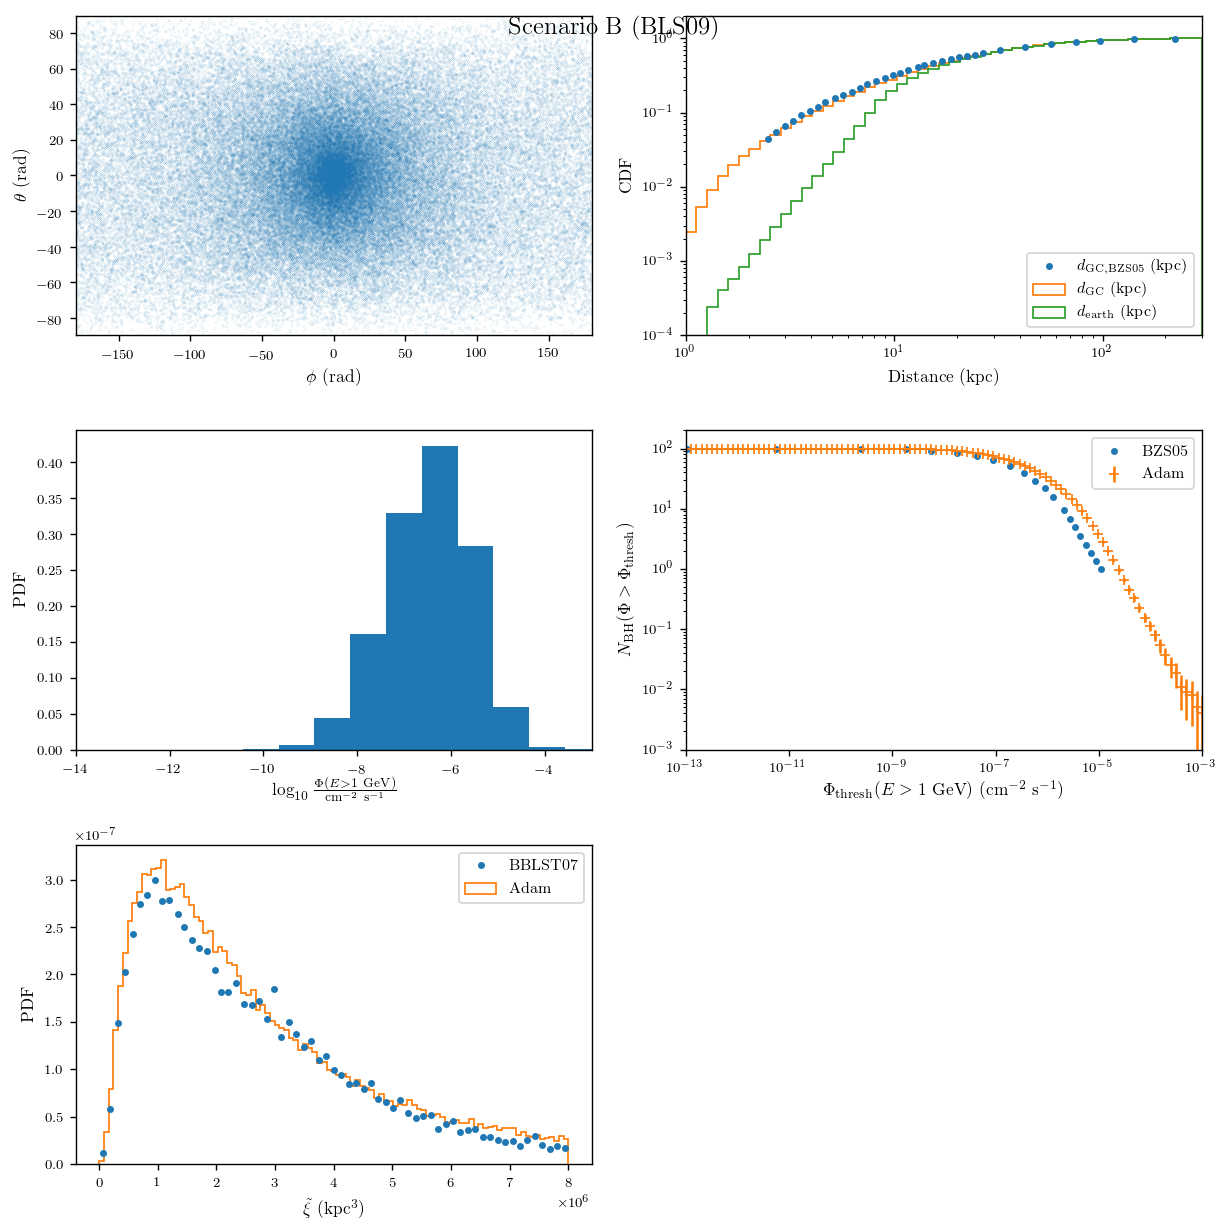

In [14]:
# Checking BH positions
plt.figure(figsize=(10, 10))

# Check angular distribution
plt.subplot(3, 2, 1)
plt.plot(positions[2], positions[1], '.', markersize=0.1)
plt.xlabel(r"$\phi$ (rad)")
plt.ylabel(r"$\theta$ (rad)")
plt.autoscale(axis="both", tight=True)

# Check radial distribution against BZS05 fig 2
plt.subplot(3, 2, 2)
plt.loglog(rs_gf, cdf_r_gf, '.', label=r"$d_{\mathrm{GC,BZS05}}$ (kpc)")
r_bins = np.logspace(0, np.log10(300), 50)
plt.hist(rs, density=True, bins=r_bins, cumulative=True,
         histtype="step", label=r"$d_{\mathrm{GC}}$ (kpc)");
plt.hist(positions[0], density=True, bins=r_bins, cumulative=True,
         histtype="step", label=r"$d_{\mathrm{earth}}$ (kpc)");
plt.xlabel(r"Distance (kpc)")
plt.ylabel("CDF")
plt.legend(loc="lower right")
plt.autoscale(axis="x", tight=True)
plt.ylim(1e-4, 2e0)

# Fluxes above 1 GeV
plt.subplot(3, 2, 3)
plt.hist(np.log10(Phis), density=True)
plt.xlabel(r"$\log_{10} \frac{\Phi(E > 1~\mathrm{GeV})}{\mathrm{cm}^{-2}~\mathrm{s}^{-1}}$")
plt.ylabel(r"PDF")
plt.xlim(-14, -3)

# Check integrated luminosity function against BZS fig 4
plt.subplot(3, 2, 4)
plt.loglog(Phi_threshs_gf, ilf_gf, '.', label="BZS05")
Phi_threshs = np.logspace(-13, -3, 100)
ilf, ilf_err = n_observable_bhs(Phi_threshs)
plt.errorbar(x=Phi_threshs, y=ilf, yerr=ilf_err, fmt="+", label="Adam")
plt.xlabel(r"$\Phi_{\mathrm{thresh}}(E > 1~\mathrm{GeV})$ (cm$^{-2}$ s$^{-1}$)")
plt.ylabel(r"$N_{\mathrm{BH}}(\Phi > \Phi_{\mathrm{thresh}})$")
plt.xlim(Phi_threshs[0], Phi_threshs[-1])
plt.ylim(1e-3, 2e2)
plt.legend()

# Distribution of annihilation volumes with m_dm=1TeV, sv=3e-26cm^3/s
# Compare to BBLST07 fig 3
plt.subplot(3, 2, 5)
plt.plot(xi_tilde_bblst, pr_xi_tilde_bblst, '.', label="BBLST07")
plt.hist(xi_tildes, density=True, histtype="step", label="Adam",
         bins=np.linspace(0, 8e6, 100))
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()
plt.xlabel(r"$\tilde{\xi}$ (kpc$^3$)")
plt.ylabel("PDF")

plt.suptitle(r"Scenario B (BLS09)")
plt.tight_layout()